In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from uszipcode import SearchEngine
from IPython.display import Image

# Linear Regression w/ l2 norm (Ridge)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

# Import Data
Get data from different sources before combining
* Cleaned up EV data: TX_WA_CO_NY.csv
* Average EV price and new car data over time: Avg_EV_Price.csv
* Census data (pop, household income, zipcode): census.csv 

In [53]:
# Import data
df_reg = pd.read_csv('./Data/TX_WA_CO_NY.csv')
df_ev = pd.read_csv('./Data/Avg_EV_Price.csv')
df_c = pd.read_csv('./Data/Census Data/census.csv')

# Convert dates to datetime dtype
df_reg['Registration Date'] = pd.to_datetime(df_reg['Registration Date'])
df_ev['Month'] = pd.to_datetime(df_ev['Month'], format='%b-%y')


# Merge Data
## Aggregate Registration Data by County

In [54]:
#Aggregate by County
# create a SearchEngine object
search = SearchEngine()

# define a function to map zip codes to counties
def zipcode_to_county(zipcode):
    #This county does not get populated for some reason
    if zipcode == 75033:
        return "Collin County"
    
    zipcode_data = search.by_zipcode(zipcode)
    county = zipcode_data.county
    return county

# apply the function to create a new column "County"
df_reg['County'] = df_reg['ZIP Code'].apply(zipcode_to_county)

In [55]:
df_reg.shape

(229934, 6)

In [56]:
nan_rows = df_reg[df_reg.isna().any(axis=1)]

In [57]:
df_reg = df_reg.groupby(["State", "Registration Date", "Drivetrain Type", "County"]).agg('sum').drop(columns = ["ZIP Code"]).reset_index()

start_date = pd.to_datetime('2017-01-01')
end_date = pd.to_datetime('2021-12-31')
df_reg = df_reg[(df_reg['Registration Date'] >= start_date) & (df_reg['Registration Date'] <= end_date)]

In [58]:
df_reg[df_reg['County'] == ""]
df_reg.shape

(17006, 5)

## EV and New Car Prices

In [59]:
# merge ev data in main df
df_reg_ev = pd.merge(df_reg, df_ev, left_on='Registration Date', right_on='Month', how='left')
df_reg_ev = df_reg_ev.drop(['Month'], axis=1)

# Since we don't have ev price data for earlier dates, set all NaN to price for 2020-01-01
fill_val = {'Average EV Price' : df_ev['Average EV Price'][0], 'New Car Average' : df_ev['New Car Average'][0]}
df_reg_ev = df_reg_ev.fillna(value=fill_val)

In [60]:
# check if any nan values
nan_rows = df_reg_ev[df_reg_ev.isna().any(axis=1)]
nan_rows
df_reg_ev.shape

(17006, 7)

## Census Data

In [61]:
# merge census data
df_reg_ev_c = pd.merge(df_reg_ev, df_c, left_on=['County', "State"], right_on=['county', 'state'], how='left')

df_reg_ev_c = df_reg_ev_c.drop(['Unnamed: 0', 'county'], axis=1)

# check if any nan values
nan_rows = df_reg_ev_c[df_reg_ev_c.isna().any(axis=1)]

print(nan_rows)

# Extract info of missing census data
print('Missing census data in:')
print('counties = ',nan_rows['County'].unique())
print('states = ',nan_rows['State'].unique())
print('Total num of countires = ',len(nan_rows['County'].unique()))
print('Total entries w/ nan = ', len(nan_rows))
print('Total entries in df = ', len(df))

# The number of missing data is < 1% of total data, just drop
df_reg_ev_c = df_reg_ev_c.dropna()

df_reg_ev_c[['population', 'household_income']] = df_reg_ev_c[['population', 'household_income']].astype(int)


Empty DataFrame
Columns: [State, Registration Date, Drivetrain Type, County, Vehicle Count, Average EV Price, New Car Average, Unnamed: 0.1, population, household_income, state]
Index: []
Missing census data in:
counties =  []
states =  []
Total num of countires =  0
Total entries w/ nan =  0
Total entries in df =  19298


In [62]:
print(df_reg_ev_c.dtypes)

State                        object
Registration Date    datetime64[ns]
Drivetrain Type              object
County                       object
Vehicle Count                 int64
Average EV Price             object
New Car Average              object
Unnamed: 0.1                  int64
population                    int64
household_income              int64
state                        object
dtype: object


# Urban/Rural Divide
Source: https://www2.census.gov/geo/docs/reference/ua/2020_UA_COUNTY.xlsx 
Website: https://www.census.gov/programs-surveys/geography/guidance/geo-areas/urban-rural.html

In [72]:
county_pop_density = pd.read_excel("./Data/2020_UA_COUNTY.xlsx")#, sheet = "2020_UA_COUNTY")
county_pop_density['STATE_NAME']
def state_to_abbreviation(state):
    if state == 'Texas':
        return 'TX'
    elif state == 'New York':
        return 'NY'
    elif state == 'Colorado':
        return 'CO'
    elif state == 'Washington':
        return 'WA'
    else:
        return None # or whatever you want to return if the input is not a valid state name

county_pop_density["STATE_NAME"] = county_pop_density["STATE_NAME"].apply(state_to_abbreviation)

Exception ignored in: <function SearchEngine.__del__ at 0x7fb448ec3af0>
Traceback (most recent call last):
  File "/Users/youssefshaker/opt/anaconda3/lib/python3.8/site-packages/uszipcode/search.py", line 196, in __del__
    self.close()
  File "/Users/youssefshaker/opt/anaconda3/lib/python3.8/site-packages/uszipcode/search.py", line 202, in close
    self.ses.close()
  File "/Users/youssefshaker/opt/anaconda3/lib/python3.8/site-packages/sqlalchemy/orm/session.py", line 1723, in close
    self._close_impl(invalidate=False)
  File "/Users/youssefshaker/opt/anaconda3/lib/python3.8/site-packages/sqlalchemy/orm/session.py", line 1765, in _close_impl
    transaction.close(invalidate)
  File "/Users/youssefshaker/opt/anaconda3/lib/python3.8/site-packages/sqlalchemy/orm/session.py", line 923, in close
    transaction.close()
  File "/Users/youssefshaker/opt/anaconda3/lib/python3.8/site-packages/sqlalchemy/engine/base.py", line 2221, in close
    self._do_close()
  File "/Users/youssefshaker/o

In [73]:
county_pop_density_df = county_pop_density[["STATE_NAME","COUNTY_NAME", "POPDEN_COU"]]
county_pop_density_df['urban_flag'] = [1 if x > 500 else 0 for x in county_pop_density_df['POPDEN_COU']]
county_pop_density_df['COUNTY_NAME'] = county_pop_density_df['COUNTY_NAME'].apply(lambda x: x + ' County')
county_pop_density_df

<ipython-input-73-0cc0c194f8e7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  county_pop_density_df['urban_flag'] = [1 if x > 500 else 0 for x in county_pop_density_df['POPDEN_COU']]
<ipython-input-73-0cc0c194f8e7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  county_pop_density_df['COUNTY_NAME'] = county_pop_density_df['COUNTY_NAME'].apply(lambda x: x + ' County')


,STATE_NAME,COUNTY_NAME,POPDEN_COU,urban_flag
0,None,Autauga County,98.922916,0
1,None,Baldwin County,145.781265,0
2,None,Barbour County,28.500467,0
3,None,Bibb County,35.814001,0
4,None,Blount County,91.696680,0
...,...,...,...,...
3229,None,Yabucoa County,551.052867,1
3230,None,Yauco County,504.673516,1
3231,None,St. Croix County,491.862425,0
3232,None,St. John County,197.101643,0


In [70]:
df_gas_elec_prices = pd.read_csv("./Data/electricity_gas_prices_reformatted_filled.csv")

# Define a dictionary to map month names to numerical values
month_dict = {'Jan': '01', 'Feb': '02', 'Mar': '03', 'Apr': '04', 
              'May': '05', 'Jun': '06', 'Jul': '07', 'Aug': '08', 
              'Sep': '09', 'Oct': '10', 'Nov': '11', 'Dec': '12'}
urban_rural_dict = {"Urban" : 1.0, "Rural" : 0.0}

# Use the map() method to convert the "month" column to numerical values
df_gas_elec_prices['Month'] = df_gas_elec_prices['Month'].map(month_dict)

df_gas_elec_prices['urban_flag'] = df_gas_elec_prices['Population Type'].map(urban_rural_dict)


# Combine "year" and "month" columns into a new column in the format "YYYY-MM"
df_gas_elec_prices['year_month'] = df_gas_elec_prices['Year'].astype(str) + '-' + df_gas_elec_prices['Month']

# Convert the "year_month" column to a datetime object
df_gas_elec_prices['date'] = pd.to_datetime(df_gas_elec_prices['year_month'])


df_gas_elec_prices = df_gas_elec_prices.drop(columns = ["Unnamed: 0", "Population Type", "Year", 
                                            "Month", "year_month"])

df_gas_elec_prices


,State,Electricity Price,Gas Price,urban_flag,date
0,TX,10.490,2.139,0.0,2017-01-01
1,TX,10.490,2.083,0.0,2017-02-01
2,TX,10.490,2.089,0.0,2017-03-01
3,TX,10.490,2.195,0.0,2017-04-01
4,TX,10.490,2.187,0.0,2017-05-01
...,...,...,...,...,...
531,CO,0.157,3.691,1.0,2022-10-01
532,CO,0.152,3.429,1.0,2022-11-01
533,CO,0.152,2.979,1.0,2022-12-01
534,CO,0.153,3.479,1.0,2023-01-01


In [83]:
df = pd.merge(df_reg_ev_c, county_pop_density_df, left_on=['State','County'], right_on=['STATE_NAME','COUNTY_NAME'], how='left')
df = pd.merge(df, df_gas_elec_prices, left_on = ["State", "urban_flag" ,"Registration Date"], right_on = ["State", "urban_flag", "date"], how = "left")
df = df.drop(columns = ["Unnamed: 0.1", "state", "STATE_NAME", "COUNTY_NAME", "date", "urban_flag"])
nan_rows = df[df.isna().any(axis=1)]
print(nan_rows)

Empty DataFrame
Columns: [State, Registration Date, Drivetrain Type, County, Vehicle Count, Average EV Price, New Car Average, population, household_income, POPDEN_COU, Electricity Price, Gas Price]
Index: []


# Prediction Models
## Linear Regression
### All Data
Will run the first linear regression model with all data even though the trends do not necessarily make sense with a decrease of EV registration after 2021 for TX, NY, and CO

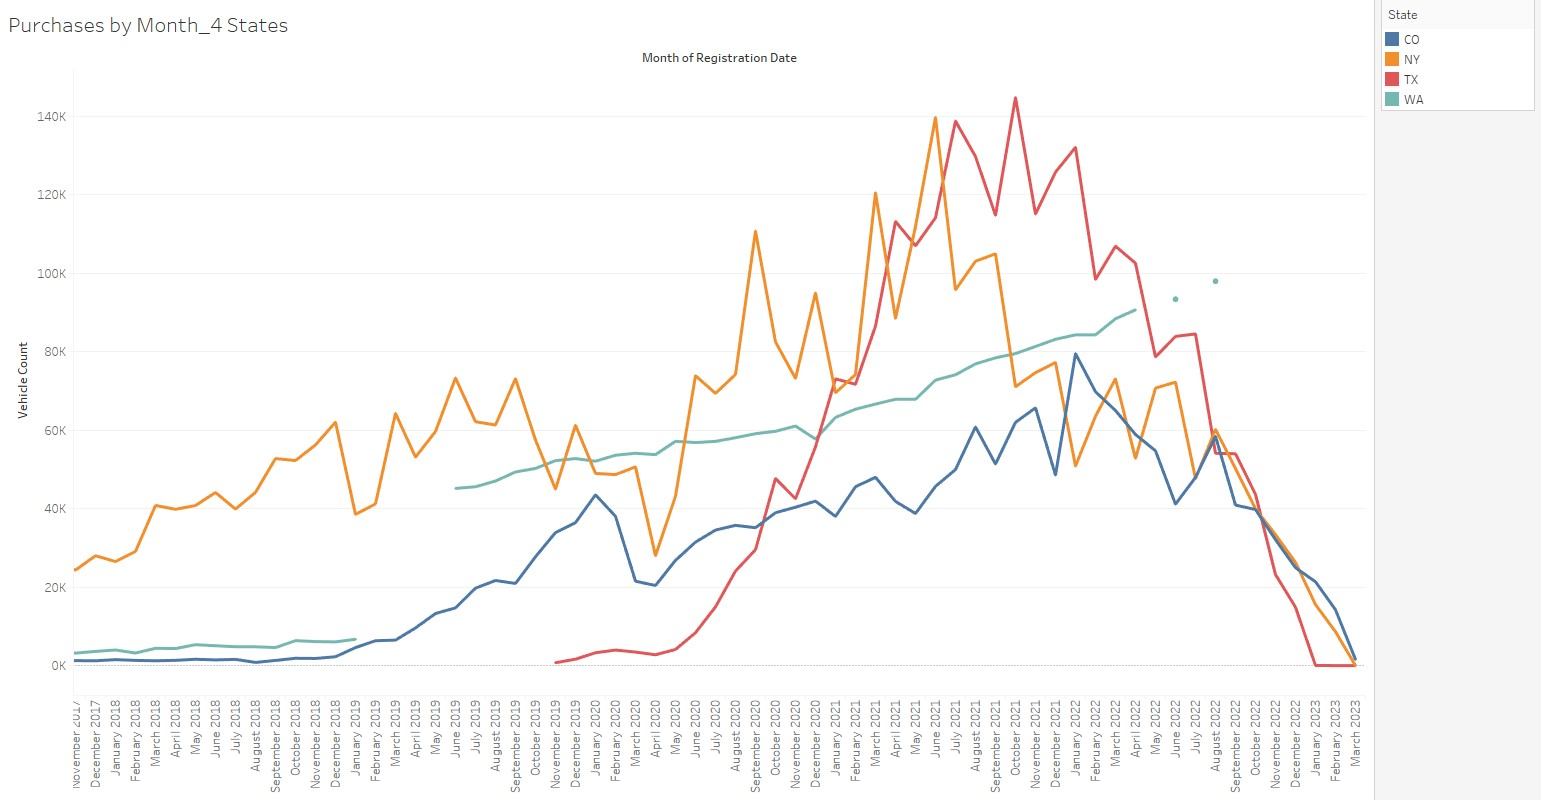

In [180]:
Image(filename='.\Figures\EV Purchases over Time for TX CO NY and WA.jpg')

In [76]:
df

,State,Registration Date,Drivetrain Type,County,Vehicle Count,Average EV Price,New Car Average,population,household_income,POPDEN_COU,Electricity Price,Gas Price
0,CO,2017-01-01,BEV,Adams County,24,"$54,669","$38,747",509844,167290,445.323695,12.660,3.378
1,CO,2017-01-01,BEV,Arapahoe County,66,"$54,669","$38,747",649980,241889,821.038725,0.112,2.089
2,CO,2017-01-01,BEV,Boulder County,170,"$54,669","$38,747",324682,127365,455.351666,12.660,3.378
3,CO,2017-01-01,BEV,Broomfield County,15,"$54,669","$38,747",69444,27199,2248.011733,0.112,2.089
4,CO,2017-01-01,BEV,Denver County,95,"$54,669","$38,747",715878,287756,4674.337363,0.112,2.089
...,...,...,...,...,...,...,...,...,...,...,...,...
17001,WA,2019-01-01,PHEV,Thurston County,84,"$54,669","$38,747",284698,112323,408.022371,9.520,3.908
17002,WA,2019-01-01,PHEV,Walla Walla County,6,"$54,669","$38,747",60785,22773,49.277735,9.520,3.908
17003,WA,2019-01-01,PHEV,Whatcom County,35,"$54,669","$38,747",224538,88978,107.617198,9.520,3.908
17004,WA,2019-01-01,PHEV,Whitman County,5,"$54,669","$38,747",49577,18485,22.217436,9.520,3.908


In [84]:
# Desired prediction var
predict_label = 'Vehicle Count'

# Drop zip code since it would increase the number of features by ~4k
# also zip code is highly correlated to population and income
# Drop registration date since we will change to Unix timestamps
drop_col = ['County', 'Registration Date']

# Assemble Categorical Variables
cat_var = ['State', 'Drivetrain Type']
for cat in cat_var:
    # Get dummy variables for cat
    dummy_var = df[cat].unique()
    dummy_var = dummy_var[1:]

    # create df w/ one hot cat features
    df_cat = pd.get_dummies(df[cat], drop_first=True)

    # drop original
    df = df.drop([cat], axis=1)

    # concatenate
    df = pd.concat([df, df_cat], axis=1)

# Add Unix timestamp   
df['Unix Time'] = df['Registration Date'].apply(lambda x: x.timestamp())

# Convert $ price into integer
df['Average EV Price'] = df['Average EV Price'].str.replace('$','').str.replace(',','').astype(int)
df['New Car Average'] = df['New Car Average'].str.replace('$','').str.replace(',','').astype(int)

df

<ipython-input-84-497f99ac9846>:29: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df['Average EV Price'] = df['Average EV Price'].str.replace('$','').str.replace(',','').astype(int)
<ipython-input-84-497f99ac9846>:30: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df['New Car Average'] = df['New Car Average'].str.replace('$','').str.replace(',','').astype(int)


,Registration Date,County,Vehicle Count,Average EV Price,New Car Average,population,household_income,POPDEN_COU,Electricity Price,Gas Price,NY,TX,WA,PHEV,Unix Time
0,2017-01-01,Adams County,24,54669,38747,509844,167290,445.323695,12.660,3.378,0,0,0,0,1.483229e+09
1,2017-01-01,Arapahoe County,66,54669,38747,649980,241889,821.038725,0.112,2.089,0,0,0,0,1.483229e+09
2,2017-01-01,Boulder County,170,54669,38747,324682,127365,455.351666,12.660,3.378,0,0,0,0,1.483229e+09
3,2017-01-01,Broomfield County,15,54669,38747,69444,27199,2248.011733,0.112,2.089,0,0,0,0,1.483229e+09
4,2017-01-01,Denver County,95,54669,38747,715878,287756,4674.337363,0.112,2.089,0,0,0,0,1.483229e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17001,2019-01-01,Thurston County,84,54669,38747,284698,112323,408.022371,9.520,3.908,0,0,1,1,1.546301e+09
17002,2019-01-01,Walla Walla County,6,54669,38747,60785,22773,49.277735,9.520,3.908,0,0,1,1,1.546301e+09
17003,2019-01-01,Whatcom County,35,54669,38747,224538,88978,107.617198,9.520,3.908,0,0,1,1,1.546301e+09
17004,2019-01-01,Whitman County,5,54669,38747,49577,18485,22.217436,9.520,3.908,0,0,1,1,1.546301e+09


In [85]:
# Get labels of all features
features = [c for c in df.columns if c not in [predict_label] + drop_col]

# extract values to np
y = df[predict_label].to_numpy()
X = df[features].to_numpy()

df = df.reset_index(drop=True)
df.to_csv('./Data/df_all_features_county.csv')
df[features].to_csv('./Data/df_X_county.csv')
df[predict_label].to_csv('./Data/df_y_county.csv')
